In [1]:
# Download needed packages
sc.install_pypi_package("pandas==1.2")
sc.install_pypi_package("matplotlib")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1625499646240_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/ff/bd/fb376f9fbad92b9a6efdbb30ff32c80f3cba1368689309cbb5566364af5c/pandas-1.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/12/33/efee2b4dabe164d82f7335132543ddab88c0dc2cf62696e631b9892f8524/Pillow-8.3.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-no

In [2]:
from pyspark.sql.functions import *
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import col, avg

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# Load taxi tripdata data into dataframes

# Green taxi tripdata 2019-05
df = spark.read.option("header",True).csv("s3://nyc-tlc/trip data/green_tripdata_2019-05.csv")

# Yellow taxi tripdata 2019-05
df_2 = spark.read.option("header",True).csv("s3://nyc-tlc/trip data/yellow_tripdata_2019-05.csv")

# Green taxi tripdata 2020-05
df_3 = spark.read.option("header",True).csv("s3://nyc-tlc/trip data/green_tripdata_2020-05.csv")

# Yellow taxi tripdata 2020-05
df_4 = spark.read.option("header",True).csv("s3://nyc-tlc/trip data/yellow_tripdata_2020-05.csv")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Select important columns
df_info = df_2.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance')
df_info_2 = df.select('lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_distance')

df_info_3 = df_4.select('tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance')
df_info_4 = df_3.select('lpep_pickup_datetime', 'lpep_dropoff_datetime', 'trip_distance')

# Rename columns to unify column names
df_info = df_info.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime"). \
withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")

df_info_2 = df_info_2.withColumnRenamed("lpep_pickup_datetime", "pickup_datetime"). \
withColumnRenamed("lpep_dropoff_datetime", "dropoff_datetime")

df_info_3 = df_info_3.withColumnRenamed("tpep_pickup_datetime", "pickup_datetime"). \
withColumnRenamed("tpep_dropoff_datetime", "dropoff_datetime")

df_info_4 = df_info_4.withColumnRenamed("lpep_pickup_datetime", "pickup_datetime"). \
withColumnRenamed("lpep_dropoff_datetime", "dropoff_datetime")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Create dataframes for 2019-05 and 2020-05 
df_2019_05 = df_info.union(df_info_2)
df_2020_05 = df_info_3.union(df_info_4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Get trip_distance values in kilometers instead of miles
mile_to_km_factor = 1.61
df_2019_05 = df_2019_05.withColumn('trip_distance_km', col('trip_distance') * mile_to_km_factor)
df_2020_05 = df_2020_05.withColumn('trip_distance_km', col('trip_distance') * mile_to_km_factor)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Change datetime format to unix_timestamp and calculate time differences in seconds
df_2019_05 = df_2019_05.withColumn("pickup_datetime_unix", unix_timestamp(col("pickup_datetime"))). \
withColumn("dropoff_datetime_unix", unix_timestamp(col("dropoff_datetime"))). \
withColumn("DiffInSeconds", col("dropoff_datetime_unix") - col("pickup_datetime_unix"))

df_2020_05 = df_2020_05.withColumn("pickup_datetime_unix", unix_timestamp(col("pickup_datetime"))). \
withColumn("dropoff_datetime_unix", unix_timestamp(col("dropoff_datetime"))). \
withColumn("DiffInSeconds", col("dropoff_datetime_unix") - col("pickup_datetime_unix"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Calculate velocity in km/h
df_2019_05 = df_2019_05.withColumn("velocity", col('trip_distance_km') / col('DiffInSeconds') * 3600)
df_2020_05 = df_2020_05.withColumn("velocity", col('trip_distance_km') / col('DiffInSeconds') * 3600)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Get records that have valocity between 0 km/h and 150 km/h and are from May respective year
df_2019_05_reduced = df_2019_05.select(when((col("velocity") > 0) & (col("velocity") < 150) & (col('pickup_datetime')[1:7] == '2019-05'), col("velocity")), col('pickup_datetime'))
df_2020_05_reduced = df_2020_05.select(when((col("velocity") > 0) & (col("velocity") < 150) & (col('pickup_datetime')[1:7] == '2020-05'), col("velocity")), col('pickup_datetime'))

# Rename columns
df_2019_05_reduced = df_2019_05_reduced.withColumnRenamed("CASE WHEN (((velocity > 0) AND (velocity < 150)) AND (substring(pickup_datetime, 1, 7) = 2019-05)) THEN velocity END", "velocity")
df_2020_05_reduced = df_2020_05_reduced.withColumnRenamed("CASE WHEN (((velocity > 0) AND (velocity < 150)) AND (substring(pickup_datetime, 1, 7) = 2020-05)) THEN velocity END", "velocity")

# Drop any rows with null values
df_2019_05_reduced = df_2019_05_reduced.na.drop()
df_2020_05_reduced = df_2020_05_reduced.na.drop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#------------------------------------------------------------------------------------By day-------------------------------------------------------------------------------------------
# Get day from datatime
df_2019_05_date = df_2019_05_reduced.withColumn("pickup_datetime", col('pickup_datetime')[9:2] )
df_2020_05_date = df_2020_05_reduced.withColumn("pickup_datetime", col('pickup_datetime')[9:2] )

# Compute mean velocity for each day
df_2019_05_mean_date = df_2019_05_date.groupBy("pickup_datetime").mean('velocity')
df_2020_05_mean_date = df_2020_05_date.groupBy("pickup_datetime").mean('velocity')

# Count number of taxis for each day
df_2019_05_count_date = df_2019_05_date.groupBy("pickup_datetime").count()
df_2020_05_count_date = df_2020_05_date.groupBy("pickup_datetime").count()

# Join dataframes together
df_2019_05_joined_date = df_2019_05_mean_date.join(df_2019_05_count_date, ["pickup_datetime"])
df_2020_05_joined_date = df_2020_05_mean_date.join(df_2020_05_count_date, ["pickup_datetime"])

# Sort by date
df_2019_05_joined_date = df_2019_05_joined_date.sort(col("pickup_datetime"))
df_2020_05_joined_date = df_2020_05_joined_date.sort(col("pickup_datetime"))

import pandas

# Convert dataframes to pandas
pd_df_2019_05_date = df_2019_05_joined_date.toPandas()
pd_df_2020_05_date = df_2020_05_joined_date.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
#------------------------------------------------------------------------------------By hour------------------------------------------------------------------------------------------

# Get hour from datatime
df_2019_05_hour = df_2019_05_reduced.withColumn("pickup_datetime", col('pickup_datetime')[12:2] )
df_2020_05_hour = df_2020_05_reduced.withColumn("pickup_datetime", col('pickup_datetime')[12:2] )


# Compute mean velocity for each pickup hour
df_2019_05_mean_hour = df_2019_05_hour.groupBy("pickup_datetime").mean('velocity')
df_2020_05_mean_hour = df_2020_05_hour.groupBy("pickup_datetime").mean('velocity')

# Count number of taxis for each pickup hour
df_2019_05_count_hour = df_2019_05_hour.groupBy("pickup_datetime").count()
df_2020_05_count_hour = df_2020_05_hour.groupBy("pickup_datetime").count()

# Join dataframes together
df_2019_05_joined_hour = df_2019_05_mean_hour.join(df_2019_05_count_hour, ["pickup_datetime"])
df_2020_05_joined_hour = df_2020_05_mean_hour.join(df_2020_05_count_hour, ["pickup_datetime"])

# Sort by hour
df_2019_05_joined_hour = df_2019_05_joined_hour.sort(col("pickup_datetime"))
df_2020_05_joined_hour = df_2020_05_joined_hour.sort(col("pickup_datetime"))


# Convert dataframes to pandas
pd_df_2019_05_hour = df_2019_05_joined_hour.toPandas()
pd_df_2020_05_hour = df_2020_05_joined_hour.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

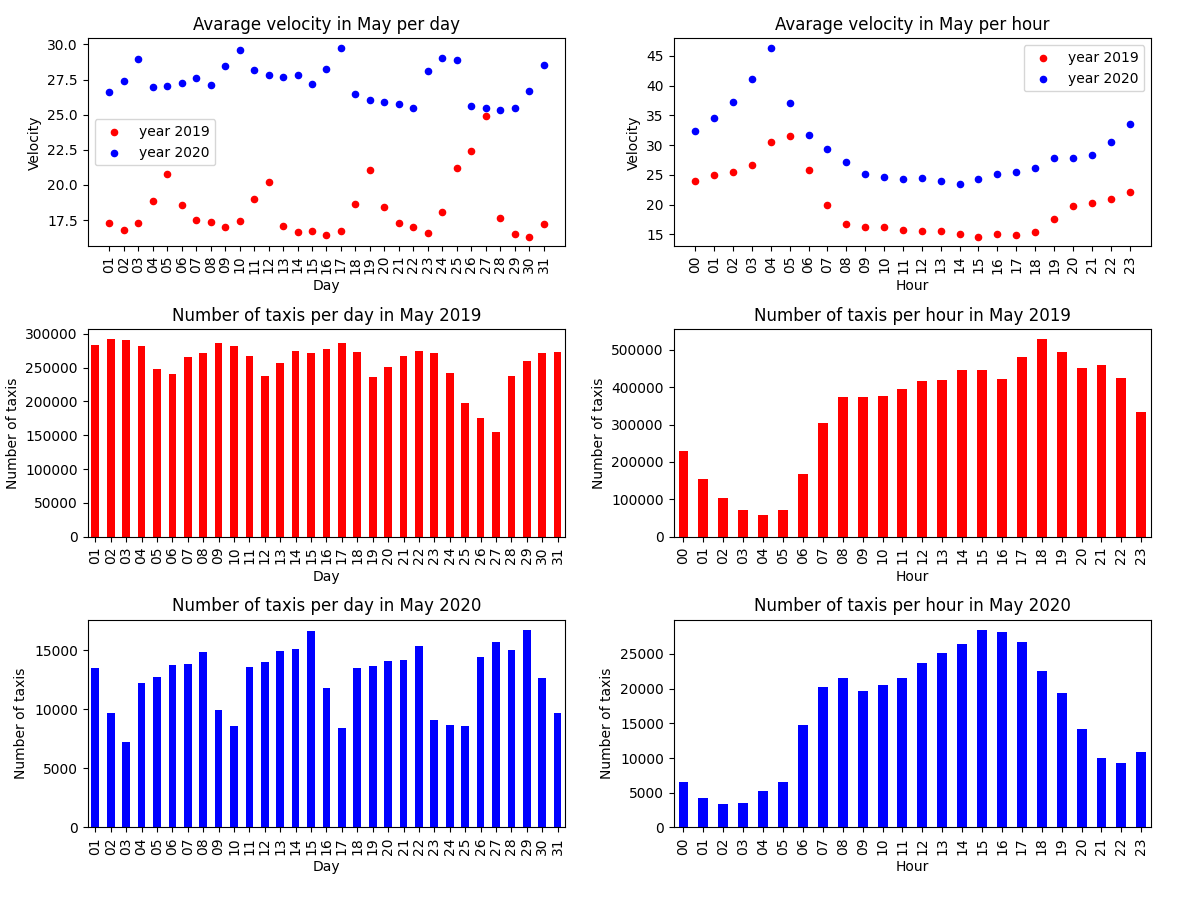

In [12]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=3, ncols=2)
fig.tight_layout()

plot_1 = pd_df_2019_05_date.plot.scatter(x="pickup_datetime", y="avg(velocity)" , color='red', label='year 2019', figsize=(12,9), ax=axes[0,0])
plot_1 = pd_df_2020_05_date.plot.scatter(x="pickup_datetime", y="avg(velocity)" , color='blue', label='year 2020', ax=axes[0,0])
plt.setp(plot_1.xaxis.get_majorticklabels(), rotation=90)
plot_1.set_title('Avarage velocity in May per day')
plot_1.set_xlabel('Day')
plot_1.set_ylabel('Velocity')

plot_2 = pd_df_2019_05_date.plot.bar(x="pickup_datetime", y="count" , color='red', ax=axes[1,0])
plot_2.get_legend().remove()
plot_2.set_title('Number of taxis per day in May 2019')
plot_2.set_xlabel('Day')
plot_2.set_ylabel('Number of taxis')

plot_3 = pd_df_2020_05_date.plot.bar(x="pickup_datetime", y="count" , color='blue', ax=axes[2,0])
plot_3.get_legend().remove()
plot_3.set_title('Number of taxis per day in May 2020')
plot_3.set_xlabel('Day')
plot_3.set_ylabel('Number of taxis')

plot_4 = pd_df_2019_05_hour.plot.scatter(x="pickup_datetime", y="avg(velocity)" , color='red', label='year 2019', figsize=(12,9), ax=axes[0,1])
plot_4 = pd_df_2020_05_hour.plot.scatter(x="pickup_datetime", y="avg(velocity)" , color='blue', label='year 2020', ax=axes[0,1])
plt.setp(plot_4.xaxis.get_majorticklabels(), rotation=90)
plot_4.set_title('Avarage velocity in May per hour')
plot_4.set_xlabel('Hour')
plot_4.set_ylabel('Velocity')


plot_5 = pd_df_2019_05_hour.plot.bar(x="pickup_datetime", y="count" , color='red', ax=axes[1,1])
plot_5.get_legend().remove()
plot_5.set_title('Number of taxis per hour in May 2019')
plot_5.set_xlabel('Hour')
plot_5.set_ylabel('Number of taxis')

plot_6 = pd_df_2020_05_hour.plot.bar(x="pickup_datetime", y="count" , color='blue', ax=axes[2,1])
plot_6.get_legend().remove()
plot_6.set_title('Number of taxis per hour in May 2020')
plot_6.set_xlabel('Hour')
plot_6.set_ylabel('Number of taxis')

%matplot plt